# Digit Recognizer

Our goal is correctly identify digits handwritten images.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [1]:
#importing liraries
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read train 
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column to get X_train
X_train = train.drop(labels = ["label"],axis = 1) 

C:\Users\mikhi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

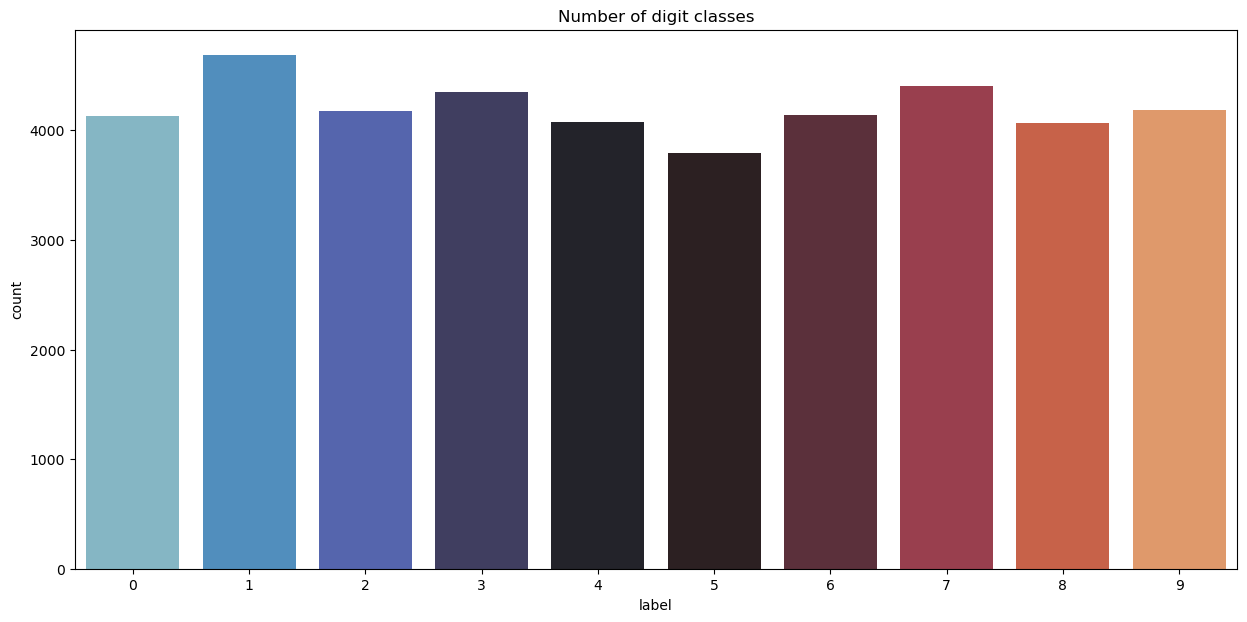

In [4]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

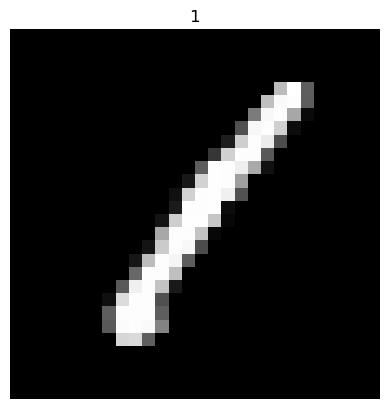

In [5]:
# plot some samples
img = X_train.iloc[0].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

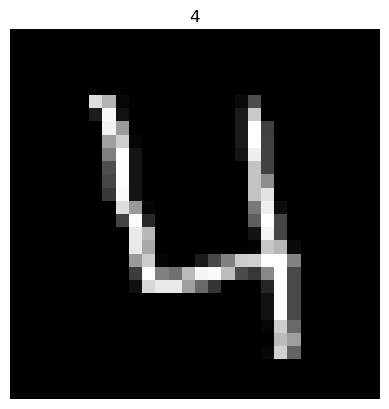

In [6]:
# plot some samples
img = X_train.iloc[3].to_numpy()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

Perform a grayscale normalization to reduce the effect of illumination's differences. When images are normalized, the pixel values are adjusted to have the same scale and range. It reduces the amount of information that the CNN needs to process, which can make the training and inference processes faster.

In [7]:
# Normalize the data
X_train = X_train / 255.0
print("x_train shape: ",X_train.shape)

x_train shape:  (42000, 784)


Train images are of the size (28x28). We need to reshape the data to a 4D tensor of size (28, 28, 1) for each image. This is because Keras needs an extra dimension in the end which correspond to channels.

In [8]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)

x_train shape:  (42000, 28, 28, 1)


Encode labels to one hot vectors

2 => [0,0,1,0,0,0,0,0,0,0]

4 => [0,0,0,0,1,0,0,0,0,0]

In [9]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
# Split the train and the test set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_test.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_test.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


# Convolutional Neural Network

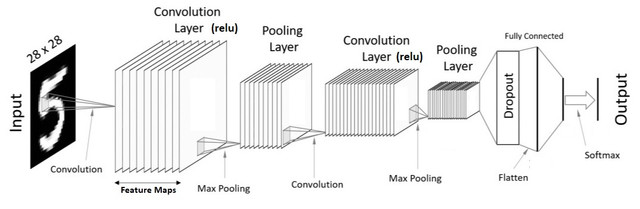

conv => max pool => dropout => conv => max pool => dropout => fully connected

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [12]:
# Compile the model
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

**Data Augmentation**

To avoid overfitting problem, we need to expand artificially our handwritten digit dataset

Alter the training data with small transformations to reproduce the variations of digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.

In [13]:
from keras.preprocessing.image import ImageDataGenerator
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

The vertical_flip nor horizontal_flip is not applied since it could have lead to misclassify symetrical numbers such as 6 and 9.

In [14]:
epochs = 20
batch_size = 250

In [15]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/20
151/151 [==============================] - 8s 51ms/step - loss: 1.0658 - accuracy: 0.6433 - val_loss: 0.2149 - val_accuracy: 0.9443
Epoch 2/20
151/151 [==============================] - 9s 58ms/step - loss: 0.4117 - accuracy: 0.8714 - val_loss: 0.1224 - val_accuracy: 0.9640
Epoch 3/20
151/151 [==============================] - 8s 56ms/step - loss: 0.3074 - accuracy: 0.9034 - val_loss: 0.0968 - val_accuracy: 0.9724
Epoch 4/20
151/151 [==============================] - 8s 50ms/step - loss: 0.2515 - accuracy: 0.9228 - val_loss: 0.0890 - val_accuracy: 0.9755
Epoch 5/20
151/151 [==============================] - 8s 50ms/step - loss: 0.2219 - accuracy: 0.9308 - val_loss: 0.0798 - val_accuracy: 0.9755
Epoch 6/20
151/151 [==============================] - 8s 50ms/step - loss: 0.2053 - accuracy: 0.9362 - val_loss: 0.0692 - val_accuracy: 0.9800
Epoch 7/20
151/151 [==============================] - 8s 50ms/step - loss: 0.1879 - accuracy: 0.9418 - val_loss: 0.0672 - val_accuracy: 0.9798

**Evaluating the Model**

Text(0, 0.5, 'Accuracy')

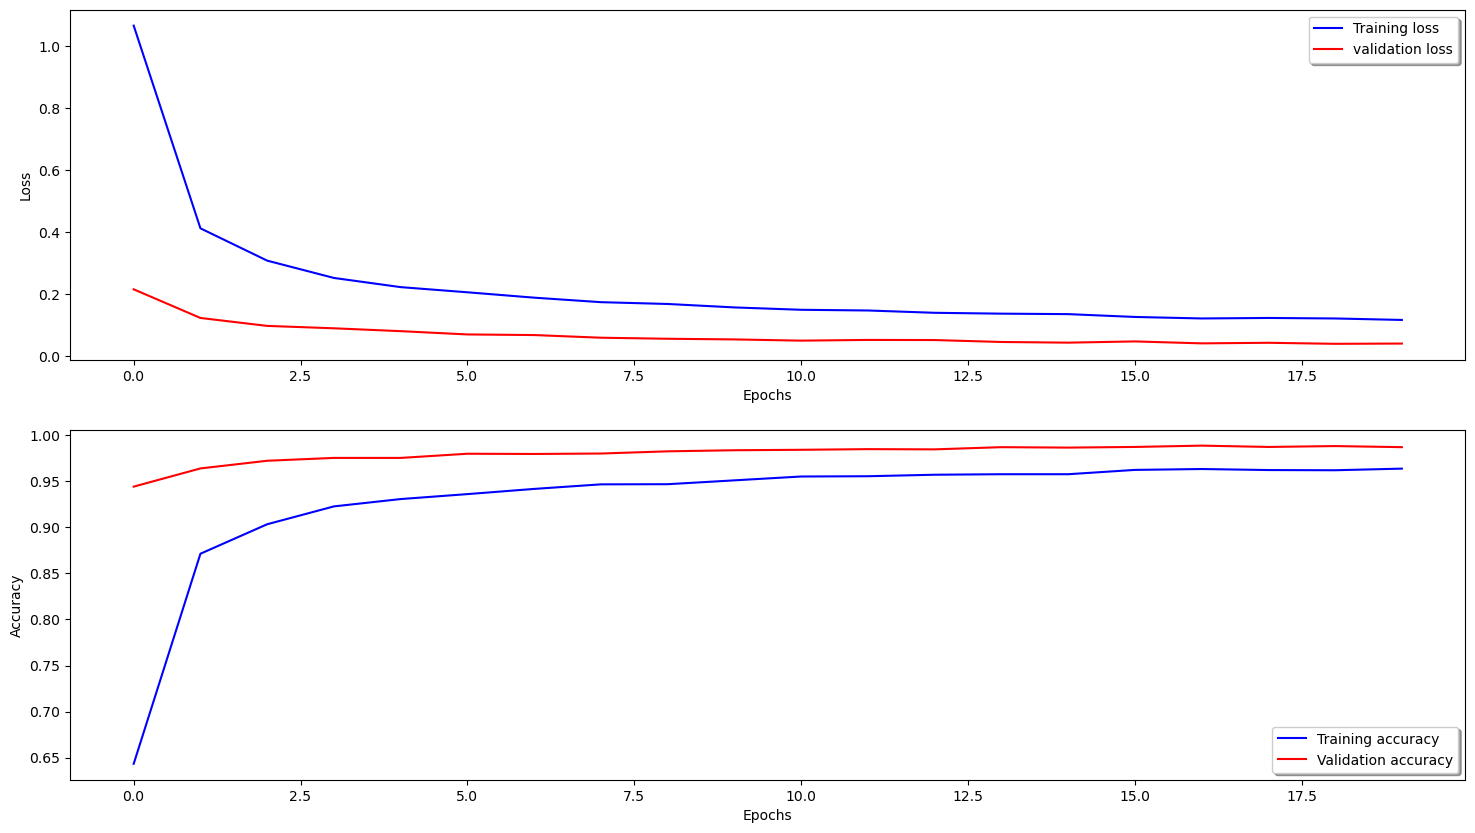

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")


ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

132/132 [==============================] - 0s 3ms/step


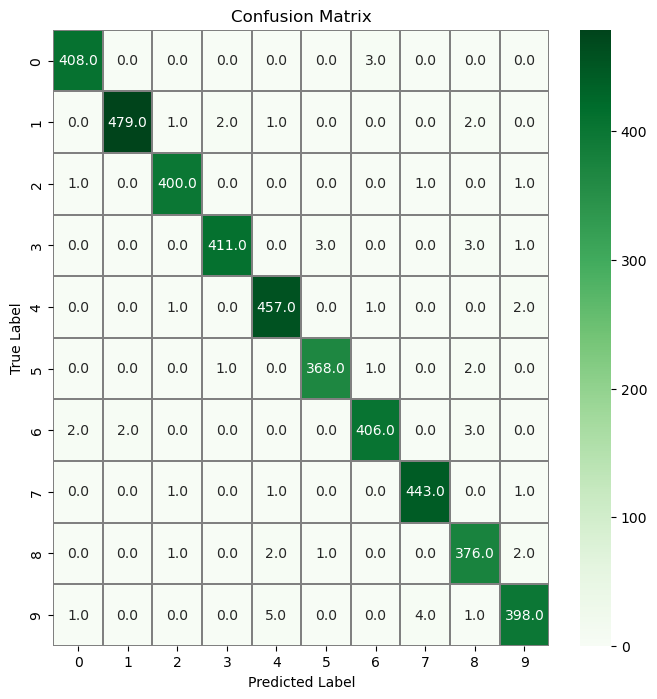

In [17]:
from sklearn.metrics import confusion_matrix
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Prediction**

132/132 [==============================] - 0s 3ms/step


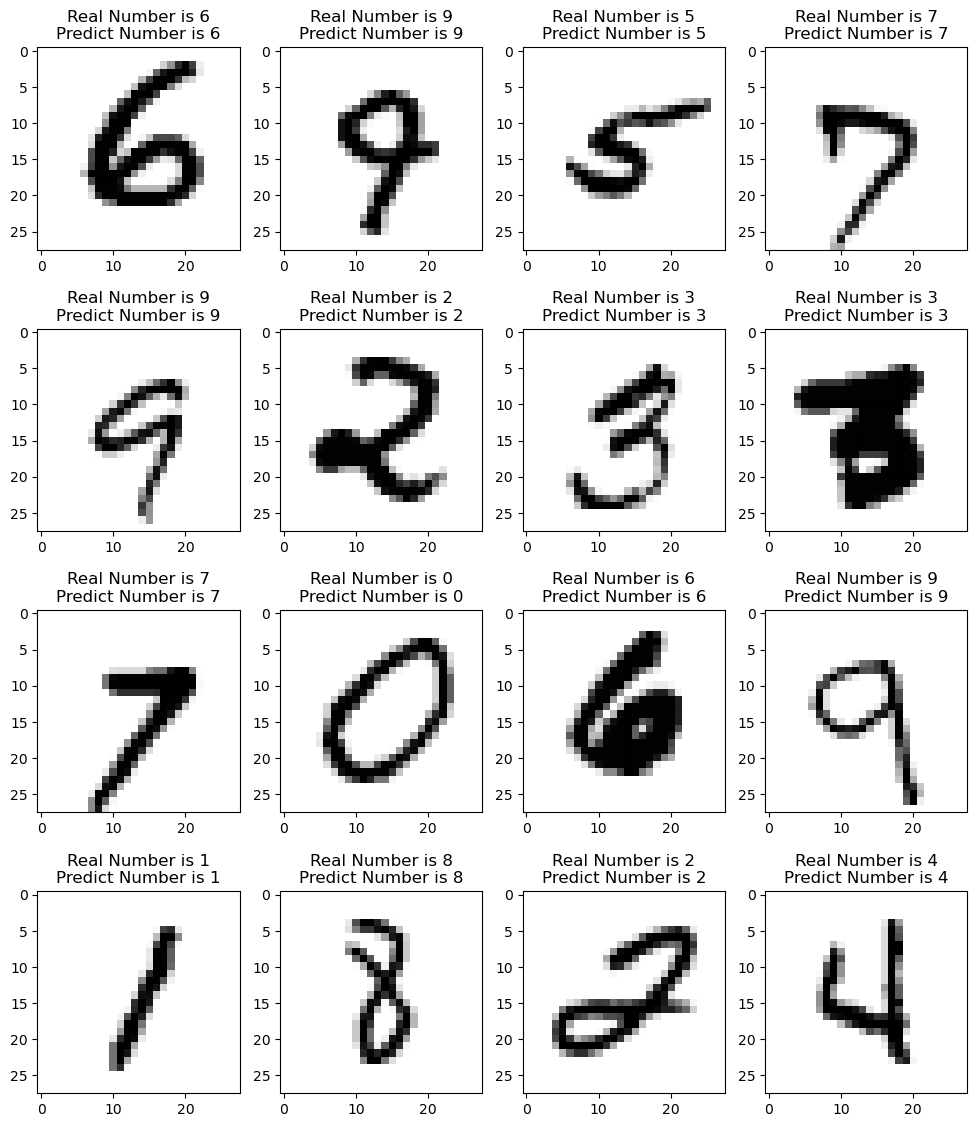

In [18]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {Y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

**References**

1. https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial/notebook
2. https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook